# Модель предсказания прерывистого временного ряда

    Данный алгоритм представляет собой единый ансамбль моделей нейронных сетей. На вход алгоритму подается батч, состоящий из 10 временных промежутков (дней). В цикле первая модель, на основе полученного батча, определяет, должна ли быть в этот день продажа. Затем вторая модель (если первая модель определила, что в этот день должна быть продажа), на основе все того же батча, определяет, сколько едениц товара может быть продано

In [1]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.10.0
GPU is ON


## Этап 1. Преобразование данных

Первым этапом выполняется преобразование входных данных в нужный формат. Функция _delete_duplicte автоматически проверяет набор данных и извлекает дублирующиеся строки, затем суммирует их значения, и удалет лишиние данные.

In [2]:
def _delete_duplicte (df):
    df_2 = df.copy()
    for i in range(1, len(df)):
        if df.iloc[i].date == df.iloc[i-1].date:
            df_2 = df_2.drop(df_2[df_2.date == df.iloc[i].date].index)
            n_count = df.iloc[i]['count'] + df.iloc[i-1]['count']
            new_row = {'date':df.iloc[i].date, 'count':n_count}
            df_2 = df_2.append(new_row, ignore_index=True)
    return df_2

In [3]:
df = pd.read_csv('96sku265.csv', sep = ",", parse_dates = ['date'])  #
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)

In [4]:
df = _delete_duplicte(df)
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)
df = df.set_index('date')


s = pd.Series(df.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df.reset_index().date)[0], list(df.reset_index().date)[-1]), fill_value=0)


df = s.to_frame(name='count')
df.index.name='date'

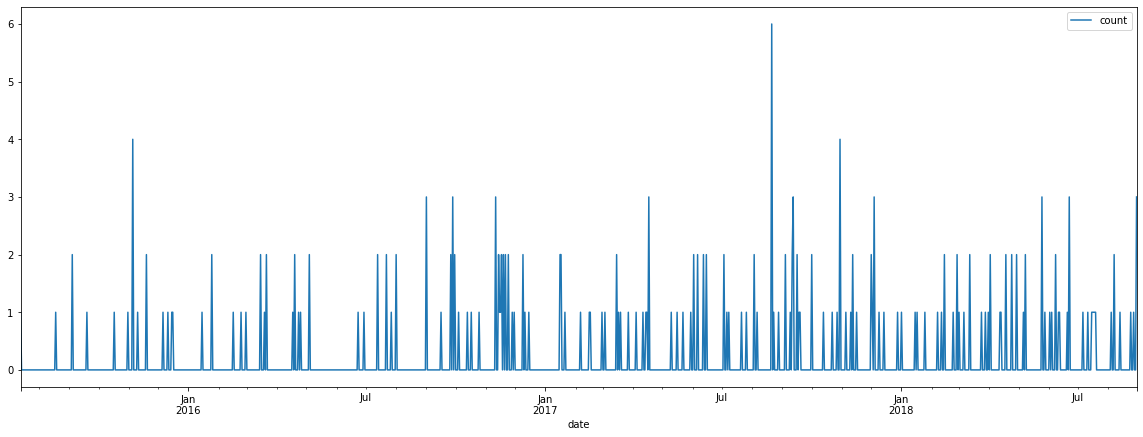

In [5]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Этап 2. Загружаем разработанные модели

In [6]:
t_point = round(0.7*len(df))
train = df.iloc[:t_point]
test = df.iloc[t_point:]

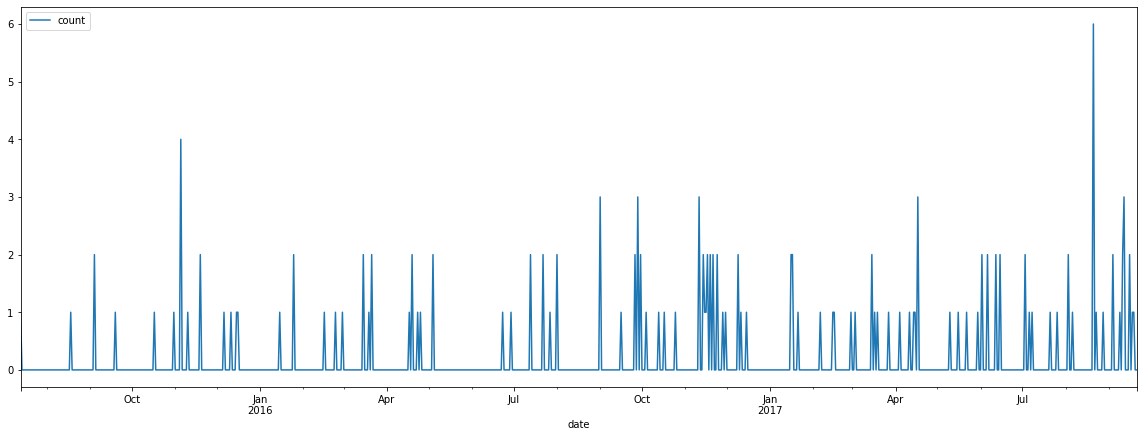

In [7]:
train.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

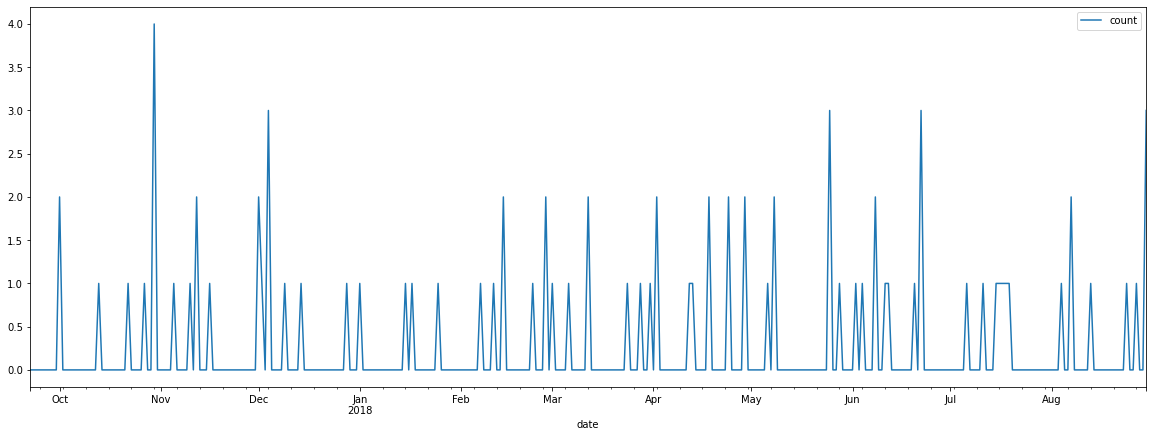

In [8]:
test.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [11]:
def buying_score(y_true, y_pred):
    return (1+y_pred)/(1+y_true)

In [12]:
model_1 = tf.keras.models.load_model('./Best_Models/YesNoModel.h5', 
                                     custom_objects={'buying_score':buying_score})  # Модель для определения будет ли продажа, или нет

model_2 = tf.keras.models.load_model('./Best_Models/SellsModel.h5', 
                                     custom_objects={'buying_score':buying_score})  # Модель для предсказания числа продаж

In [13]:
n_input = 10
n_features = 1

# Тестируем полученную модель

## Эксперимент 1

Первым этапом тестируем полученную модель на тестовом наборе данных (343 дня) высокочастотной номенклуатауры

In [14]:
test_predictions = []

first_eval_batch = np.array(test)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


for i in range(n_input-1):
    test_predictions.append(np.array(test)[i]) 
try:
    for i in range(len(df)-3): 
        current_pred = np.argmax(model_1.predict(current_batch))
        if current_pred == 1: current_pred = round(model_2.predict(current_batch)[0][0])
        test_predictions.append([current_pred])#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(test)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


In [16]:
test_copy = test.copy()
test_copy['Predictions'] = np.array(test_predictions[:343])
test_copy

,count,Predictions
date,,
2017-09-22,0,0
2017-09-23,0,0
2017-09-24,0,0
2017-09-25,0,0
2017-09-26,0,0
...,...,...
2018-08-26,0,1
2018-08-27,1,0
2018-08-28,0,1


<AxesSubplot:xlabel='date'>

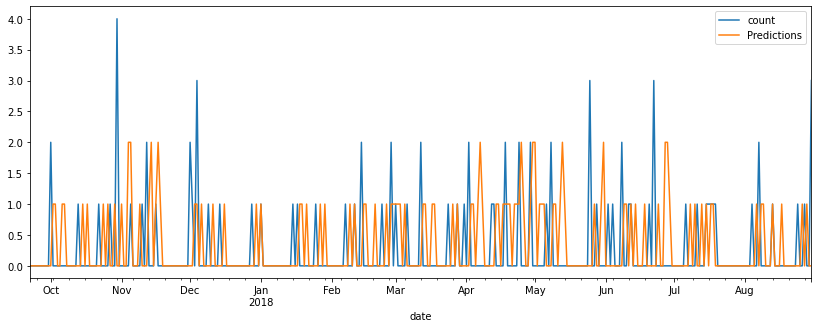

In [17]:
test_copy.plot(figsize=(14,5))

In [18]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))

mean(metric_list)

1.2015063168124394

In [19]:
Bought = sum(list(test_copy['Predictions']))
Sold = sum(list(test_copy['count']))
Bought, Sold

(112, 84)

In [20]:
print('Перезакуп {} {}'.format (Bought - Sold, Bought/Sold)) if Bought/Sold > 1 else print('Недозакуп {} {}'.format (Bought - Sold, Bought/Sold))

Перезакуп 28 1.3333333333333333


## Эксперимент 2

Вторым этапом тестируем полученную модель полном наборе данных (>1000 дней) высокочастотной номенклуатауры

In [21]:
test_predictions = []

first_eval_batch = np.array(df)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


for i in range(n_input-1):
    test_predictions.append(np.array(df)[i]) 
try:
    for i in range(len(df)-3): 
        current_pred = np.argmax(model_1.predict(current_batch))
        if current_pred == 1: current_pred = round(model_2.predict(current_batch)[0][0])
        test_predictions.append([current_pred])#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


In [23]:
test_copy = df.copy()
test_copy['Predictions'] = np.array(test_predictions)
test_copy

,count,Predictions
date,,
2015-07-13,1,1
2015-07-14,0,0
2015-07-15,0,0
2015-07-16,0,0
2015-07-17,0,0
...,...,...
2018-08-26,0,1
2018-08-27,1,0
2018-08-28,0,1


<AxesSubplot:xlabel='date'>

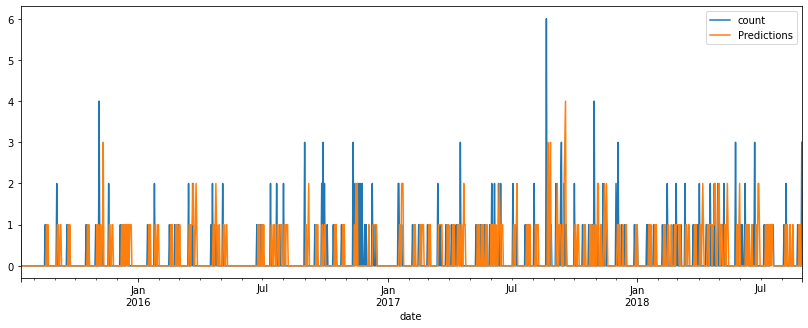

In [24]:
test_copy.plot(figsize=(14,5))

In [25]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))

mean(metric_list)

1.167868579746309

In [26]:
Bought = sum(list(test_copy['Predictions']))
Sold = sum(list(test_copy['count']))
Bought, Sold

(309, 228)

In [27]:
print('Перезакуп {} {}'.format (Bought - Sold, Bought/Sold)) if Bought/Sold > 1 else print('Недозакуп {} {}'.format (Bought - Sold, Bought/Sold))

Перезакуп 81 1.355263157894737


## Эксперимент 3

Третьим этапом тестируем полученную модель полном наборе данных (>1000 дней) высокочастотной номенклуатауры. Но проверка осуществляется только последних **40** дней.

In [28]:
Bought = sum(list(test_copy['Predictions'][-40:]))
Sold = sum(list(test_copy['count'][-40:]))
Bought, Sold

(7, 9)

In [29]:
print('Перезакуп {} {}'.format (Bought - Sold, Bought/Sold)) if Bought/Sold > 1 else print('Недозакуп {} {}'.format (Bought - Sold, Bought/Sold))

Недозакуп -2 0.7777777777777778


## Эксперимент 4

Четвертым этапом выполняем предсказание высокочастотной нуменклуатуры на 40 дней вперед.

In [30]:
new_predictions = []
first_eval_batch =  np.array(df)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = np.argmax(model_1.predict(current_batch))
        if current_pred == 1: current_pred = round(model_2.predict(current_batch)[0][0])
        new_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step


In [31]:
test_copy_3 = test.copy()
test_copy_3

,count
date,
2017-09-22,0
2017-09-23,0
2017-09-24,0
2017-09-25,0
2017-09-26,0
...,...
2018-08-26,0
2018-08-27,1
2018-08-28,0


In [32]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_3.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [33]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = np.array(new_predictions)
predicted_df = predicted_df.set_index('date')

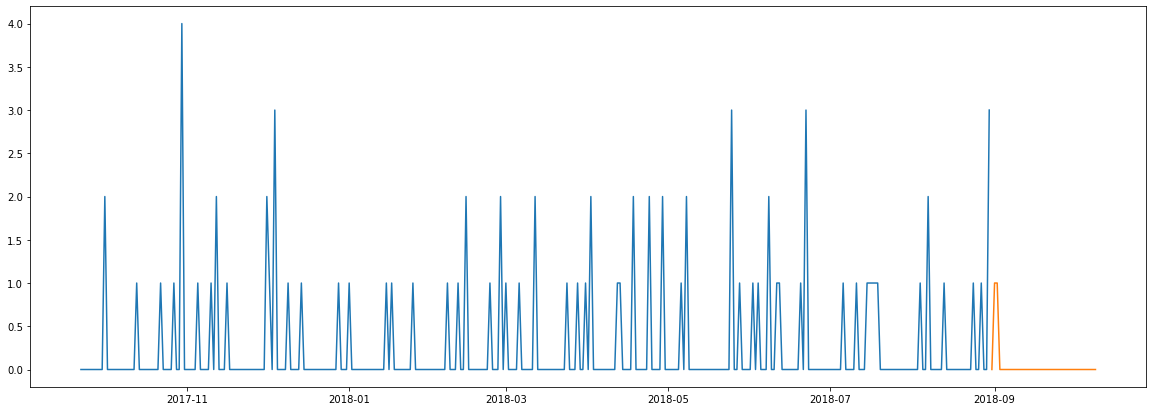

In [34]:
plt.figure(figsize = (20, 7))
plt.plot(test_copy_3)
plt.plot(predicted_df)
plt.show()

## Эксперимент 5

Пятым этапом выполняем предсказание на полном наборе данных (>400 дней) низкочастотной номенклуатауры.

In [35]:
df_2 = pd.read_csv('42sku13653.csv', sep = ",", parse_dates = ['date']) # 

In [36]:
df_2 = _delete_duplicte(df_2)
df_2 = df_2.sort_values(by=['date'])
df_2 = df_2.reset_index().drop('index', axis=1)
date = df_2['date']
df_2 =df_2.set_index('date')
s = pd.Series(df_2.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df_2.reset_index().date)[0], list(df_2.reset_index().date)[-1]), fill_value=0)
df_2 = s.to_frame(name='count')

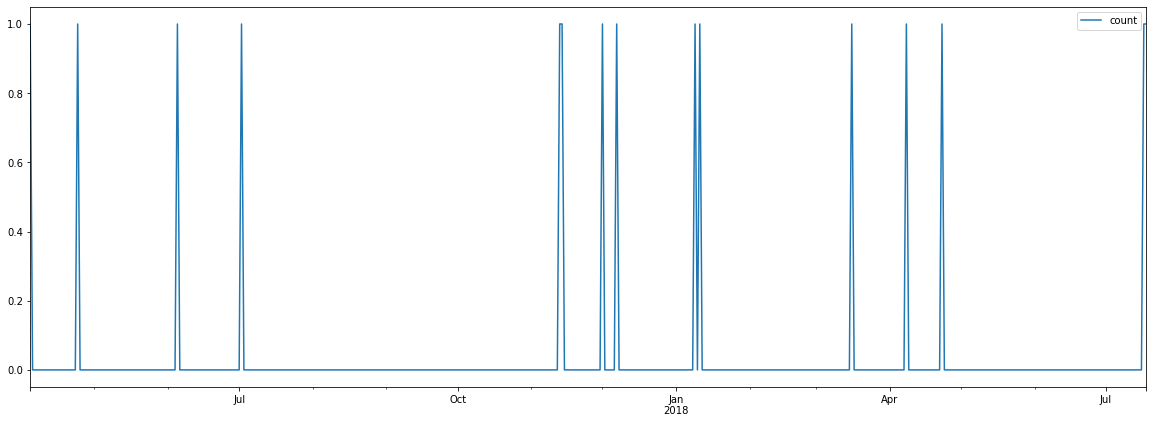

In [38]:
df_2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [39]:
df2_predictions = []
first_eval_batch = np.array(df_2)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    df2_predictions.append(np.array(df_2)[i][0]) 
    
try:
    for i in range(len(np.array(df_2))-3):
        current_pred = np.argmax(model_1.predict(current_batch))
        if current_pred == 1: current_pred = round(model_2.predict(current_batch)[0][0])
        df2_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df_2)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


In [41]:
test_copy_DF2 = df_2.copy()
test_copy_DF2['Predictions'] = np.array(df2_predictions)
test_copy_DF2

,count,Predictions
2017-04-04,1,1
2017-04-05,0,0
2017-04-06,0,0
2017-04-07,0,0
2017-04-08,0,0
...,...,...
2018-07-14,0,0
2018-07-15,0,0
2018-07-16,0,0
2018-07-17,1,0


In [42]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy_DF2['count'],test_copy_DF2['Predictions'])

0.03876266354329438

In [43]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy_DF2['count']),list(test_copy_DF2['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

1.0360934182590233

In [44]:
s = sum(list(test_copy_DF2['count']))
b = sum(list(test_copy_DF2['Predictions']))
print('Перезакуп {} {}'.format (b - s, b/s)) if b/s > 1 else print('Недозакуп {} {}'.format (b - s, b/s))

Перезакуп 10 1.6666666666666667


<AxesSubplot:>

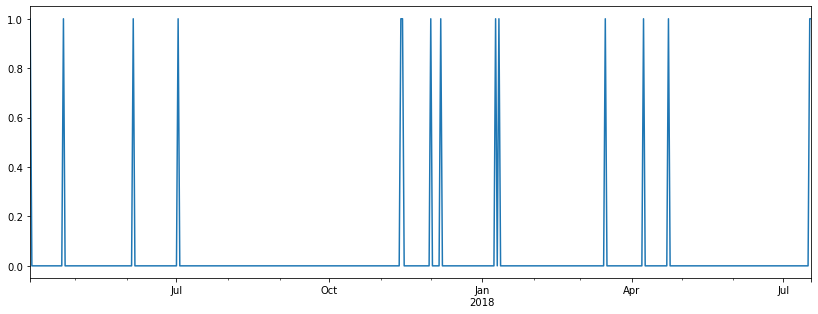

In [45]:
test_copy_DF2['count'].plot(figsize=(14,5))


<AxesSubplot:>

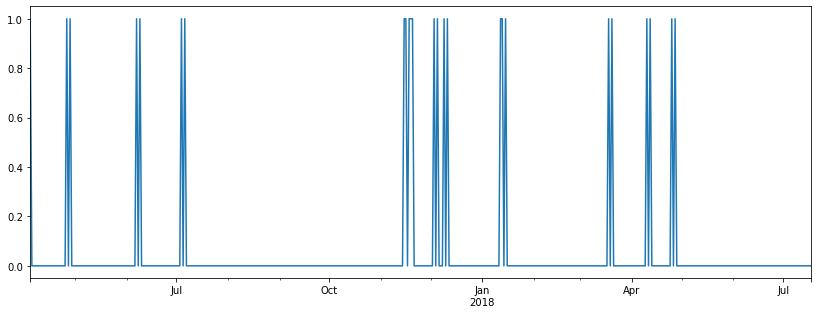

In [46]:
test_copy_DF2['Predictions'].plot(figsize=(14,5))


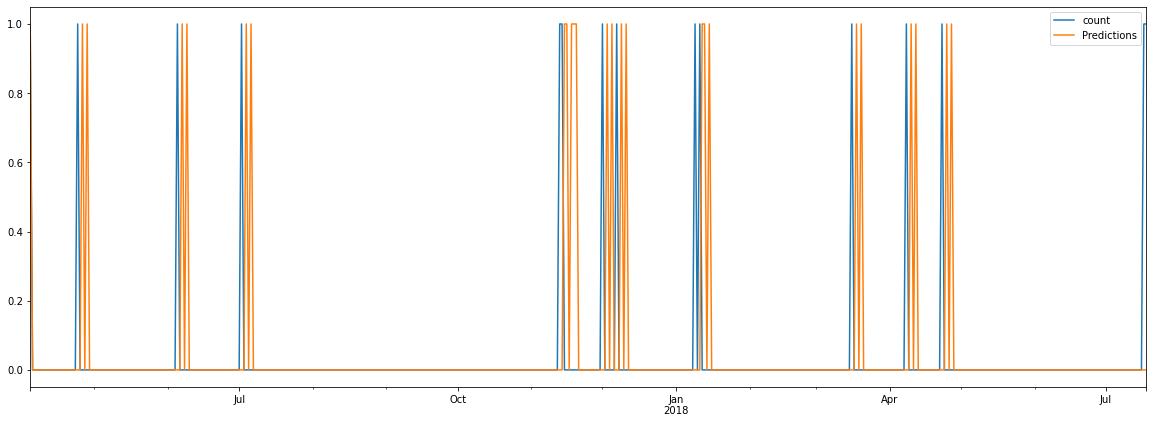

In [47]:
test_copy_DF2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Эксперимент 6

Шестым этапом выполняем предсказаниенизкочастотной нуменклуатуры на 40 дней вперед.

In [48]:
new_predictions_2 = []
first_eval_batch =  np.array(df_2)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

try:
    for i in range(40):
        current_pred = np.argmax(model_1.predict(current_batch))
        print(current_pred)
        if current_pred == 1: current_pred = round(model_2.predict(current_batch)[0][0])
        new_predictions_2.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [=======================

In [49]:
test_copy_DF2.index.name='date'
 

In [50]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_DF2.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [51]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions_2
predicted_df = predicted_df.set_index('date')

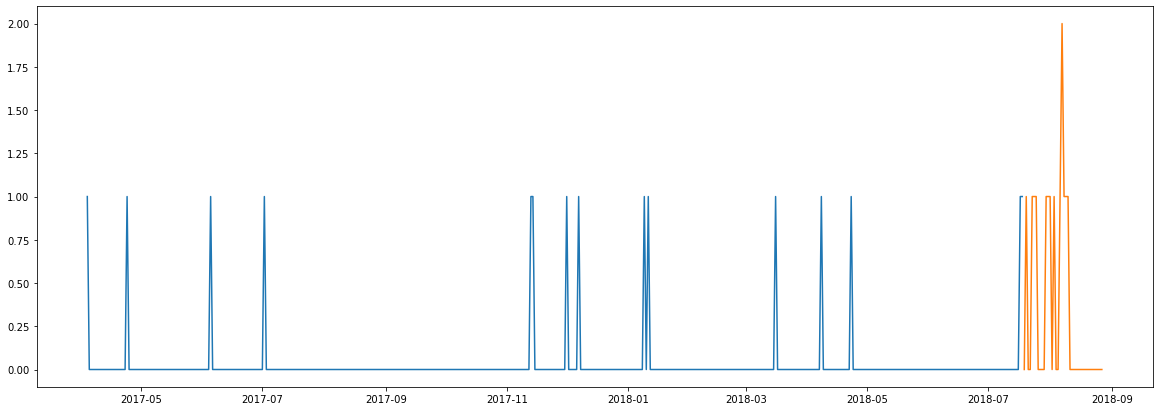

In [52]:
plt.figure(figsize = (20, 7))
plt.plot(df_2)
plt.plot(predicted_df)
plt.show()

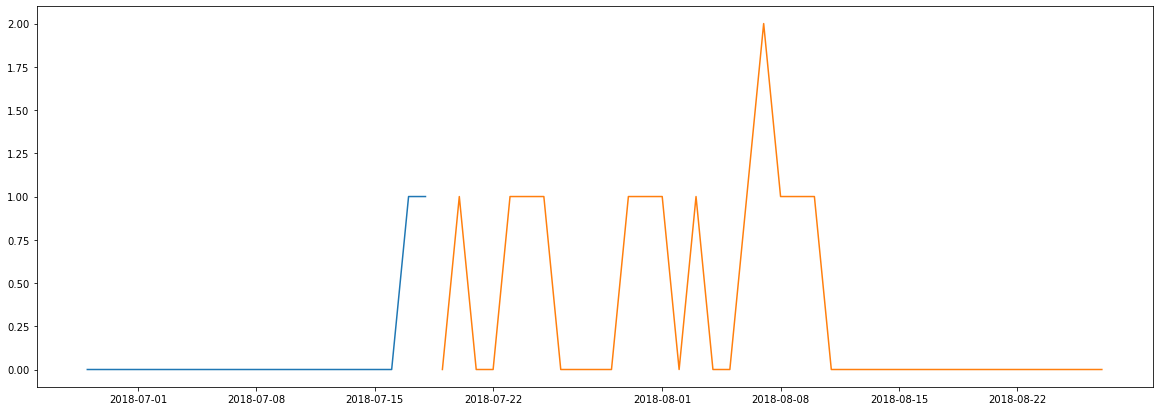

In [53]:
plt.figure(figsize = (20, 7))
plt.plot(df_2[450:])
plt.plot(predicted_df)
plt.show()